# 猫狗图像识别实践

图像识别技术可以识别出图像或者视频中的物体类别。本实验基于猫狗数据集，使用Keras手动搭建一个经典的VGG16卷积神经网络，训练一个猫狗分类模型。

## 数据集

猫狗识别数据集，猫和狗各12500张图片，图片名称中含有类别名称（cat和dog）。我们会根据图片名称中包含的类别名称（cat或dog）给图片打标签，狗的标签打成1，猫的标签打成0。

## 实践步骤

### 下载数据集

下载数据压缩包，解压，然后清理压缩包。

In [1]:
from modelarts.session import Session
session = Session()

session.download_data(
    bucket_path="modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz",
    path="./image_recognition.tar.gz")

# 使用tar命令解压资源包
!tar xf ./image_recognition.tar.gz

# 清理压缩包
!rm -f ./image_recognition.tar.gz

Successfully download file modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz from OBS to local ./image_recognition.tar.gz


### 导入依赖库

In [2]:
import os, cv2, random
import numpy as np
import pandas as pd

# 画图工具
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import Callback, EarlyStopping, TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras import backend as K
K.set_image_data_format('channels_last')

Using TensorFlow backend.


### 读取数据集

读取数据集，并把图像resize到 64 * 64 大小。

In [3]:
DATA_DIR = './data/' # 数据集路径

ROWS = 64
COLS = 64
CHANNELS = 3

image_file_names = [DATA_DIR+i for i in os.listdir(DATA_DIR)] 
dogs = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'dog' in i]
cats = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'cat' in i]

# 数据洗牌
random.shuffle(image_file_names)

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) # 彩色模式读取图像
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(image_file_names):
    count = len(image_file_names)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
    
    for i, image_file in enumerate(image_file_names):
        image = read_image(image_file)
        data[i] = image
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

# 读取图片至内存
images = prep_data(image_file_names)

Processed 0 of 25000
Processed 1000 of 25000
Processed 2000 of 25000
Processed 3000 of 25000
Processed 4000 of 25000
Processed 5000 of 25000
Processed 6000 of 25000
Processed 7000 of 25000
Processed 8000 of 25000
Processed 9000 of 25000
Processed 10000 of 25000
Processed 11000 of 25000
Processed 12000 of 25000
Processed 13000 of 25000
Processed 14000 of 25000
Processed 15000 of 25000
Processed 16000 of 25000
Processed 17000 of 25000
Processed 18000 of 25000
Processed 19000 of 25000
Processed 20000 of 25000
Processed 21000 of 25000
Processed 22000 of 25000
Processed 23000 of 25000
Processed 24000 of 25000


### 给图片打标签

我们根据图片名称包含的字符串给图片打标签。我们用0表示cat，1表示dog。

同时统计label的数量。

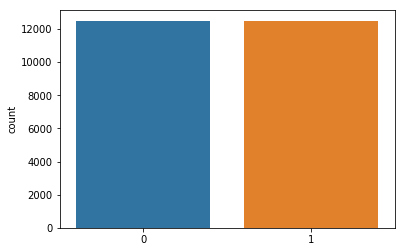

In [4]:
labels = []
for i in image_file_names:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)

### 切分数据集

（train_data，train_label）是训练数据，（test_data，test_label）是测试数据。测试数据占25%。

In [5]:
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.25, random_state=10)

### 查看样本文件及其对应的标签

In [6]:
df = pd.DataFrame({
    'data': image_file_names,
    'label': labels
})

df.head(10) # 查看前10项样本

,data,label
0,./data/dog.11611.jpg,1
1,./data/dog.6566.jpg,1
2,./data/cat.295.jpg,0
3,./data/cat.4119.jpg,0
4,./data/dog.7155.jpg,1
5,./data/dog.7957.jpg,1
6,./data/dog.1280.jpg,1
7,./data/cat.8105.jpg,0
8,./data/cat.9935.jpg,0
9,./data/cat.5312.jpg,0


### 查看猫狗的样本图片

这些图片是进过尺寸调整后的图片

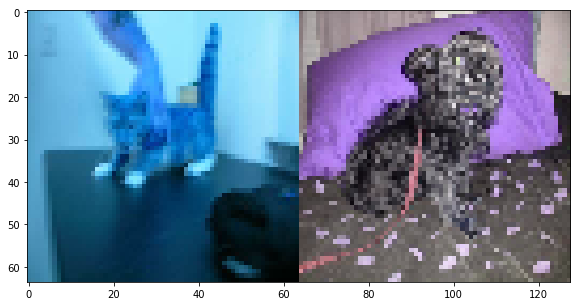

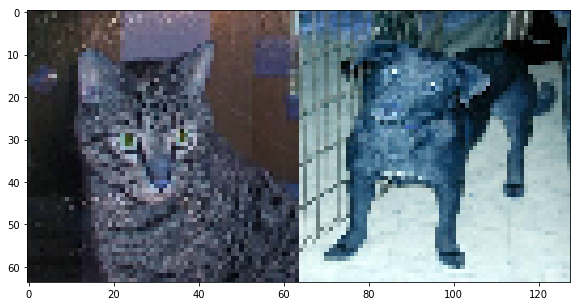

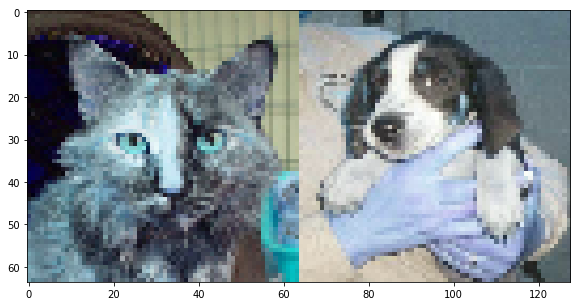

In [7]:
def show_cats_and_dogs(idx):
    cat = read_image(cats[idx])
    dog = read_image(dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,3):
    show_cats_and_dogs(idx)

### 构建神经网络

Keras是一个非常简单易用的，适合新手入门的深度学习引擎。接下来，我们使用Keras搭建一个修改版的VGG16卷积神经网络，大家可以学习到深度神经网络的搭建方式。

Keras使用一层一层堆叠的方式构建神经网络。

In [8]:
optimizer = RMSprop(lr=1e-4) # 优化器使用RMSprop, 设置学习率是1e-4
objective = 'binary_crossentropy' # loss 函数使用交叉熵

def dogcat_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(ROWS, COLS, 3), activation='relu')) # 卷积层,activation是激活函数
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last")) # 池化层

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

    model.add(Flatten()) # 铺平层
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5)) # 剪枝层
    
    model.add(Dense(256, activation='relu')) # 全连接层
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid')) # 激活函数

    # 模型配置，设置优化器和loss函数
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

model = dogcat_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### 模型结构概览

可以查看到刚刚搭建的神经网络结构的详情。

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
__________

### 模型训练

在模型训练过程中，为了防止过拟合，我们使用了early stopping策略，当val_loss在连续3个epoch不再减少的情况下，就停止训练。同时，我们还记录了训练过程中的loss。

可以看到训练日志输出，其中会打印Loss（损失函数）和acc（精确度）信息。

In [10]:
epochs = 10 # 训练轮数
batch_size = 16 # 批大小

# Loss记录
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# early stopping策略
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')   

def run_catdog():
    history = LossHistory()
    
    # 开始训练
    model.fit(
        train_data, 
        train_label, 
        batch_size=batch_size, 
        epochs=epochs,
        validation_split=0.25,  # 训练数据中，抽取25%的数据作为验证数据
        verbose=2,
        shuffle=True,
        callbacks=[history, early_stopping]) 
    
    return  history

history = run_catdog()

Instructions for updating:
Use tf.cast instead.


Train on 14062 samples, validate on 4688 samples
Epoch 1/10
 - 10s - loss: 0.6691 - acc: 0.5859 - val_loss: 0.6095 - val_acc: 0.6762
Epoch 2/10
 - 6s - loss: 0.5568 - acc: 0.7148 - val_loss: 0.5104 - val_acc: 0.7455
Epoch 3/10
 - 6s - loss: 0.4979 - acc: 0.7657 - val_loss: 0.4600 - val_acc: 0.7873
Epoch 4/10
 - 6s - loss: 0.4400 - acc: 0.8002 - val_loss: 0.4379 - val_acc: 0.7984
Epoch 5/10
 - 6s - loss: 0.3953 - acc: 0.8271 - val_loss: 0.4377 - val_acc: 0.8230
Epoch 6/10
 - 6s - loss: 0.3584 - acc: 0.8504 - val_loss: 0.4161 - val_acc: 0.8223
Epoch 7/10
 - 6s - loss: 0.3234 - acc: 0.8660 - val_loss: 0.4080 - val_acc: 0.8259
Epoch 8/10
 - 6s - loss: 0.2852 - acc: 0.8873 - val_loss: 0.4936 - val_acc: 0.8003
Epoch 9/10
 - 6s - loss: 0.2555 - acc: 0.8976 - val_loss: 0.4474 - val_acc: 0.8191
Epoch 10/10
 - 6s - loss: 0.2250 - acc: 0.9117 - val_loss: 0.5157 - val_acc: 0.8223
Epoch 00010: early stopping


### 保存模型

训练好的模型可以保存起来，永久使用。

In [11]:
OUTPUT = 'output'

if not os.path.exists(OUTPUT):
    os.mkdir(OUTPUT)

model.save(os.path.join(OUTPUT, 'model.h5'))

### 可视化训练过程

将Loss随epoch的变化趋势使用折线图展示

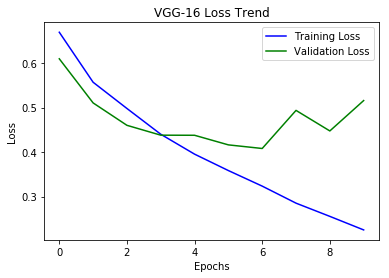

In [12]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

### 样本数据预测

直观展示10个样本数据的预测结果

I am 89.75% sure this is a Dog


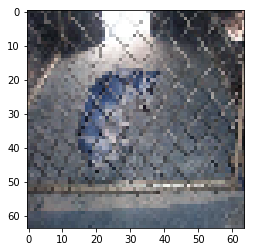

I am 82.51% sure this is a Cat


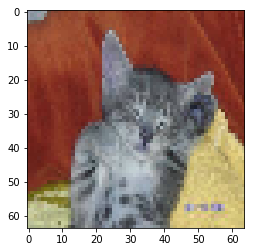

I am 94.68% sure this is a Cat


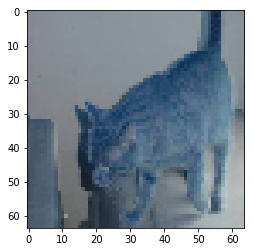

I am 50.91% sure this is a Cat


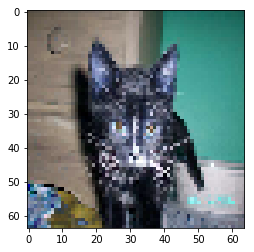

I am 76.76% sure this is a Cat


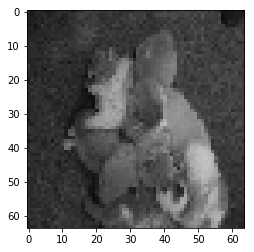

I am 99.94% sure this is a Dog


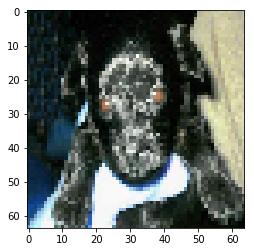

I am 89.38% sure this is a Cat


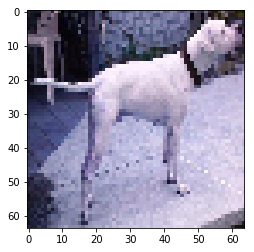

I am 54.95% sure this is a Cat


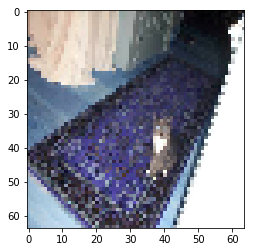

I am 98.91% sure this is a Dog


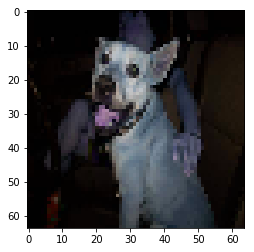

I am 95.09% sure this is a Cat


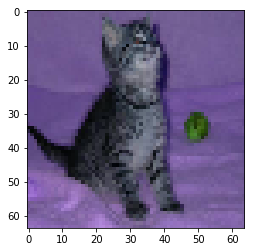

In [13]:
# 预测测试集
predictions = model.predict(test_data, verbose=0)

for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1 - predictions[i][0]))
        
    plt.imshow(test_data[i])
    plt.show()

### 评估模型准确度

通过测试集的预测结果，计算模型的准确度。

In [14]:
predictions_test = []
for p in predictions:
    predictions_test.append(int(round(p[0])))

acc = accuracy_score(test_label, predictions_test)

print('训练得到的猫狗识别模型的准确度是：',acc)

训练得到的猫狗识别模型的准确度是： 0.8256


## 小结

本实验使用Keras搭建了一个VGG16神经网络，并使用猫狗数据集训练了一个猫狗识别模型。